In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader

/home/ubuntu-user/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 定义深度卷积神经网络模型
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.classifier1 = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.unknown_class = num_classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def open_set_forward(self, x, known_classes):
        x = self.features(x)
        #print(x.shape) 
        x = x.view(x.size(0), -1)
        #print(x.shape) 
        logits = self.classifier(x)

        # 计算每个样本的开放集得分
        open_scores = torch.softmax(logits[:, known_classes], dim=1)

        # 添加未知类别得分
        unknown_scores = torch.zeros(x.size(0), 1).to(x.device)
        open_scores = torch.cat((open_scores, unknown_scores), dim=1)

        return open_scores

In [3]:
# 训练闭集模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

In [4]:
# 测试开放集识别
def test(model, test_loader, known_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            open_scores = model.open_set_forward(images, known_classes)
            _, predicted = torch.max(open_scores.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy}%")

In [5]:
# 设置随机种子和设备
torch.manual_seed(2024)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


In [6]:
# 数据预处理和加载器
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''

'\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((32, 32)),\n    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n])\n'

In [7]:

# Define the transformations for CIFAR10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [8]:
# Define the transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


In [10]:
# 加载CIFAR10测试集
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform_cifar)
testloader = DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


In [11]:
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_mnist)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [12]:
# 初始化模型、损失函数和优化器
num_classes = 10  # 已知类别数量
model = Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [13]:
# 训练模型
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.2129053109137298
Epoch [2/10], Loss: 0.8234892089272399
Epoch [3/10], Loss: 0.6108180547080686
Epoch [4/10], Loss: 0.40568915773611847
Epoch [5/10], Loss: 0.2274753119262969
Epoch [6/10], Loss: 0.11673366661895723
Epoch [7/10], Loss: 0.07750897227769808
Epoch [8/10], Loss: 0.06907095500122747
Epoch [9/10], Loss: 0.06015420969798351
Epoch [10/10], Loss: 0.049995646672978365


In [14]:

class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of class {i}: {accuracy:.2f}%')

Accuracy of class 0: 73.70%
Accuracy of class 1: 82.60%
Accuracy of class 2: 63.50%
Accuracy of class 3: 47.20%
Accuracy of class 4: 70.30%
Accuracy of class 5: 57.30%
Accuracy of class 6: 66.40%
Accuracy of class 7: 76.00%
Accuracy of class 8: 78.80%
Accuracy of class 9: 76.50%


In [15]:
# 测试模型
test(model, test_loader, known_classes=list(range(num_classes)))

Test Accuracy: 7.48%


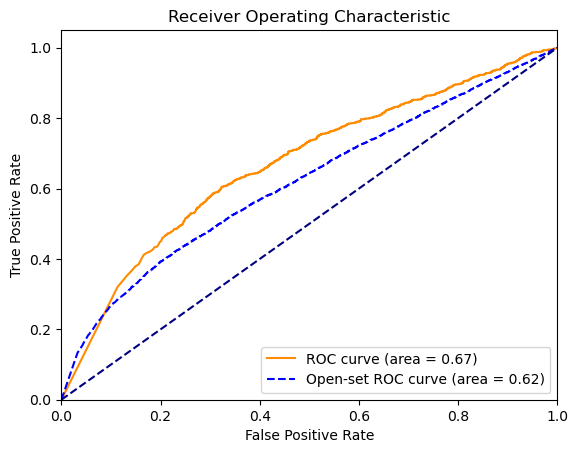

In [16]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# 计算开放集似然性
def calculate_open_set_likelihood(testloader, open_set_loader):
    model.eval()
    softmax = nn.Softmax(dim=1)

    scores = []
    labels = []

    with torch.no_grad():
        for data in testloader:
            images, true_labels = data
            outputs = model(images)
            probabilities = softmax(outputs)
            max_probabilities, _ = torch.max(probabilities, 1)
            scores.extend(max_probabilities.cpu().numpy())
            labels.extend(true_labels.cpu().numpy())

    open_set_scores = []

    with torch.no_grad():
        for data in open_set_loader:
            images, _ = data
            outputs = model(images)
            probabilities = softmax(outputs)
            max_probabilities, _ = torch.max(probabilities, 1)
            open_set_scores.extend(max_probabilities.cpu().numpy())

    return np.array(scores), np.array(open_set_scores), np.array(labels)

# 计算似然性并绘制ROC曲线
scores, open_set_scores, labels = calculate_open_set_likelihood(testloader, test_loader)

fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
roc_auc = auc(fpr, tpr)

open_set_fpr, open_set_tpr, _ = roc_curve(np.concatenate((np.ones_like(labels), np.zeros_like(open_set_scores))), np.concatenate((scores, open_set_scores)))
open_set_roc_auc = auc(open_set_fpr, open_set_tpr)

# 绘制ROC曲线
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(open_set_fpr, open_set_tpr, color='blue', linestyle='--', label='Open-set ROC curve (area = %0.2f)' % open_set_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()